<a href="https://colab.research.google.com/github/giovani-gutierrez/giovani-gutierrez.github.io/blob/main/LING111_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.6 MB/s eta 0:00:00


In [2]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore') # ignore warnings
sns.set_theme() # set plot theme

In [3]:
# data
dataset = pd.read_csv('https://raw.githubusercontent.com/leonardtang/The-Naughtyformer/b0f0b3419b986b9a7c375140ea0e41e8ade810e8/cleaned_data.csv')
dataset.head()

,joke_type,score,title,selftext
0,0,39,Sherlock Holmes and Dr Watson were going camping.,They pitched their tent under the stars and we...
1,0,4,"some cheesy ones, but they're some of my favor...",What's a ghost's favorite thing to get at the ...
2,0,12,What kind of horses go out after dark?,Nightmares!
3,0,28,A man in Alaska was feeling lonely...,So he decided to get a puppy. After finding a ...
4,0,13,Where did George Washington keep his armies?,In his sleevies!


In [4]:
# make copy
df1 = dataset.copy()

# concat title & selftext
df1['joke'] = dataset['title'].astype(str) + ' ' + dataset['selftext'].astype(str)

# drop unnecessary columns
df1.drop(columns = ['title', 'selftext'], inplace = True)

# preview
df1 = df1.astype({'joke': str})
df1.dtypes

joke_type     int64
score         int64
joke         object
dtype: object

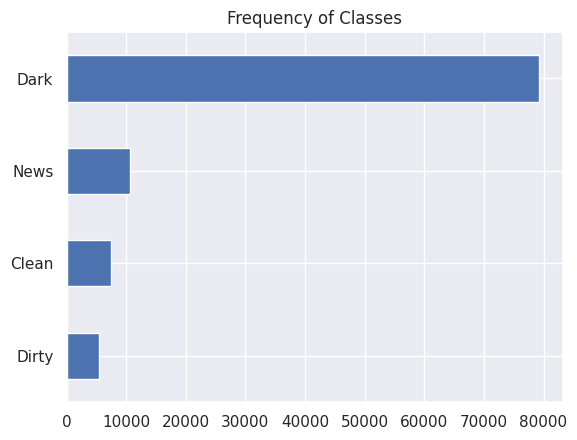

joke_type    object
score        object
joke         object
dtype: object

In [5]:
df2 = df1.replace({0:'Clean', 
                   1: 'Dark', 
                   2: 'Dirty', 
                   3: 'News'})

df2['joke_type'].value_counts(ascending = True).plot.barh()
plt.title("Frequency of Classes")
plt.show()
df2.dtypes

In [6]:
df2.head()

,joke_type,score,joke
0,Clean,39,Sherlock Holmes and Dr Watson were going campi...
1,Clean,4,"some cheesy ones, but they're some of my favor..."
2,Clean,12,What kind of horses go out after dark? Nightma...
3,Clean,28,A man in Alaska was feeling lonely... So he de...
4,Clean,13,Where did George Washington keep his armies? I...


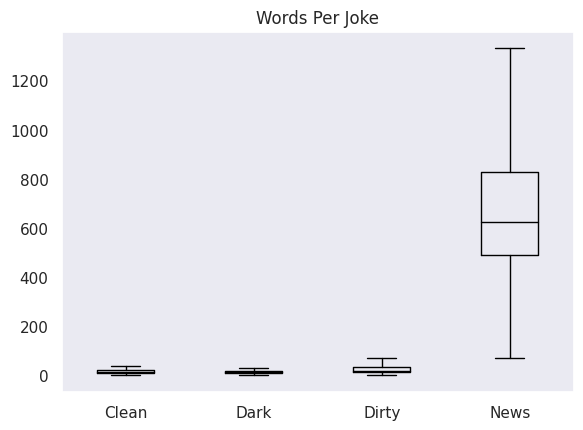

In [7]:
df2['Words Per Joke'] = df2['joke'].str.split().apply(len)
df2.boxplot('Words Per Joke', by = 'joke_type', grid = False,
          showfliers = False, color = 'black')
plt.suptitle("")
plt.xlabel("")
plt.show()

In [8]:
# DistilBERT
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model & tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# filter out sentences that result in token lengths longer than 512
max_length = tokenizer.model_max_length
tokenized = df2['joke'].apply((lambda x: tokenizer.encode(x[:max_length], add_special_tokens=True, truncation=True))) # tokenizer

In [10]:
# padding
max_len = 0
for sent in tokenized.values:
    if len(sent) > max_len:
        max_len = len(sent)

padded = np.array([sent + [0]*(max_len-len(sent)) for sent in tokenized.values])

In [11]:
np.array(padded).shape

(102863, 472)

In [12]:
# mask the padding when processing input
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(102863, 472)

In [ ]:
# Run DistilBERT
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
  last_hidden_states = model(input_ids, attention_mask=attention_mask)